### This notebook is for this Kaggle Challenge: https://www.kaggle.com/c/Kannada-MNIST
### Here is my Kaggle Karnel for the same: https://www.kaggle.com/kaushal2896/kannada-mnist-using-cnn
### Got `0.98680` accuracy using CNN
![alt text](https://i.ibb.co/M8LVxrv/Screenshot-2019-09-29-at-2-37-08-PM.png)


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


### Define required constants
Image size is `28*28` as per the MNIST standards and images are grayscale, so number of channels is `1`.

In [0]:
# constants
IMG_SIZE = 28
N_CHANNELS = 1 # because gray scale images

In [0]:
train_df = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test_df = pd.read_csv('/kaggle/input/Kannada-MNIST/Dig-MNIST.csv')
pred_df = pd.read_csv('/kaggle/input/Kannada-MNIST/test.csv')

In [0]:
train_df = train_df.append(test_df)

In [0]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
print (f'Training set: {train_df.shape}')
print (f'To be Predicted: {pred_df.shape}')

Training set: (70240, 785)
To be Predicted: (5000, 785)


In [0]:
X_train = train_df.drop(['label'], axis = 1)
Y_train = train_df['label']
X_pred = pred_df.drop(['id'], axis = 1)

### Split the given dataset into training and testing dataset

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.05)

### Normalize the images 

In [0]:
X_train, X_test, X_pred = X_train.apply(lambda x: x/255), X_test.apply(lambda x: x/255), X_pred.apply(lambda x: x/255)

### Convert training and testing labels (Ys) to one hot encoding

In [0]:
Y_train, Y_test = pd.get_dummies(Y_train), pd.get_dummies(Y_test)

### CNN takes images in shape `(batch_size, h, w, channels)`, so reshape the images

In [0]:
X_train = X_train.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)
X_test = X_test.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS)

In [0]:
print (f'Training images: {X_train.shape}')
print (f'Testing images: {X_test.shape}')

Training images: (66728, 28, 28, 1)
Testing images: (3512, 28, 28, 1)


In [0]:
Y_train = Y_train.to_numpy()

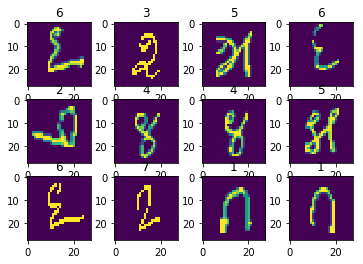

In [0]:
fig, ax = plt.subplots(nrows=3, ncols=4)
count=0
for row in ax:
    for col in row:
        col.set_title(np.argmax(Y_train[count, :]))
        col.imshow(X_train[count, :, :, 0])
        count += 1
plt.show()

### Apply data augmentation:
To get more training data, to avoid overfitting, data augmentation is used. Data augmentation is the creation of altered copies of each training instance (image) within a training dataset. 
I've used following data augmentation for this problem:
* Ramdomly rotate the images by 8 degrees
* Randomly zoom the images by 15%
* Randomly shift its height and width by 15%

In [0]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.15, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


# This will just calculate parameters required to augment the given data. This won't perform any augmentations
datagen.fit(X_train)

### Create CNN model using Keras

In [0]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='SAME', activation='relu'))
model.add(Dropout(rate=0.3))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
model.add(BatchNormalization(momentum=0.15))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(5, 5), padding='SAME', activation='relu'))
model.add(Dropout(rate=0.3))

model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.40))
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.40))
model.add(Dense(10, activation = "softmax"))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        25632     
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)       

In [0]:
model.compile(optimizer="adam", loss=['categorical_crossentropy'], metrics=['accuracy'])

In [0]:
# Set a learning rate annealer. Learning rate will be half after 3 epochs if accuracy is not increased
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1,
                                            factor=0.5, 
                                            min_lr=0.00001)

In [0]:
batch_size=32
epochs = 25

In [0]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,Y_test),
                              steps_per_epoch=X_train.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])


Epoch 1/25
2085/2085 [==============================] - 43s 21ms/step - loss: 0.4498 - accuracy: 0.8596 - val_loss: 0.0996 - val_accuracy: 0.9741
Epoch 2/25
2085/2085 [==============================] - 41s 20ms/step - loss: 0.1502 - accuracy: 0.9626 - val_loss: 0.0634 - val_accuracy: 0.9806
Epoch 3/25
2085/2085 [==============================] - 42s 20ms/step - loss: 0.1284 - accuracy: 0.9682 - val_loss: 0.0555 - val_accuracy: 0.9841
Epoch 4/25
2085/2085 [==============================] - 41s 20ms/step - loss: 0.1069 - accuracy: 0.9734 - val_loss: 0.0489 - val_accuracy: 0.9852
Epoch 5/25
2085/2085 [==============================] - 40s 19ms/step - loss: 0.0995 - accuracy: 0.9764 - val_loss: 0.0457 - val_accuracy: 0.9886
Epoch 6/25
2085/2085 [==============================] - 41s 19ms/step - loss: 0.0950 - accuracy: 0.9772 - val_loss: 0.0395 - val_accuracy: 0.9880
Epoch 7/25
2085/2085 [==============================] - 41s 19ms/step - loss: 0.0838 - accuracy: 0.9797 - val_loss: 0.0309 -

### Ploting loss and accuracy

In [0]:
%matplotlib inline
def PlotLoss(his, epoch):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epoch), his.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.show()

def PlotAcc(his, epoch):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, epoch), his.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epoch), his.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper right")
    plt.show()

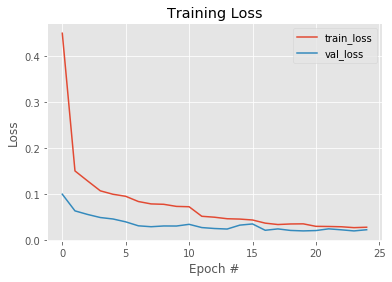

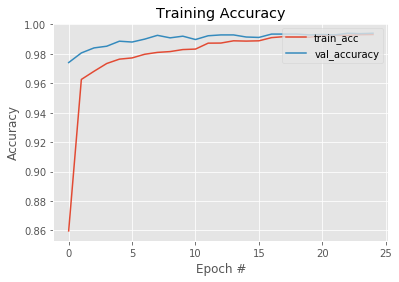

In [0]:
PlotLoss(history, epochs)
PlotAcc(history, epochs)

### Confusion matrix 

In [0]:
cfm = confusion_matrix(np.argmax(Y_test.to_numpy(), axis=1), np.argmax(model.predict(X_test), axis=1))
cfm = pd.DataFrame(cfm,index=range(0,10),columns=range(0,10))
cfm

,0,1,2,3,4,5,6,7,8,9
0,319,4,0,0,0,0,0,0,0,1
1,1,370,0,0,0,0,0,1,0,0
2,0,0,359,0,0,0,0,0,0,0
3,0,0,1,348,0,0,0,2,0,0
4,0,0,1,0,338,0,0,0,1,0
5,0,0,0,1,0,358,0,1,0,0
6,0,0,0,0,0,0,350,5,0,1
7,0,0,0,0,0,0,1,354,0,0
8,0,0,0,0,0,0,0,0,367,0
9,0,0,0,0,0,0,0,0,0,328


### Make predictions using trained model

In [0]:
preds = model.predict(X_pred.values.reshape(-1, IMG_SIZE, IMG_SIZE, N_CHANNELS))

#### Predictions will be in one hot encoding, take `argmax` to make the predictions submission ready

In [0]:
pred_df['label'] = np.argmax(preds, axis=1)

In [0]:
preds = pred_df[['id', 'label']]

#### Finally create submission file

In [0]:
preds.to_csv('sub.csv', index=False)